In [105]:
def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(kernel='gaussian',bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    return np.exp(log_pdf)




In [106]:
def bandwidth(weights):
    d = 2 # 2 dimensions for x,y coordinates.
    neff = len(x_in)
#     neff = np.sum(weights)^2 / np.sum(weights^2)

    factor = neff**(-1./(d+4))                      # Scott's Rule
#     factor = (neff * (d + 2) / 4.)**(-1. / (d + 4)) # Silverman's Rule
#     print(factor)
    return factor
    
    
    

In [107]:
import csv
import sklearn
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import NullFormatter
from sklearn.neighbors import KernelDensity
from statsmodels.stats.weightstats import DescrStatsW

x_in = []
# x-position of each particle.
y_in = []
# y-position of each particle.
p_I = []
# particle current in [Amperes].
p_KP = []
# particle power in [Watts].

# with open('1-Enpa new 1.out') as file:
# with open('1-Enpa old.out') as file:
# with open('10-Enpa.out') as file:
# with open('quick_input.out') as file:
# with open('quick_input_lower.out') as file:
# with open('0-Enpa.out') as file:
# with open('9-Enpa 3.out') as file:
with open('10-Enpa 3.out') as file:
# with open('10-Enpa b.out') as file:
# with open('10-Enpa.out') as file:
# with open('11-Enpa b.out') as file:
# with open('11-Enpa.out') as file:
# with open('11-Enpa last.out') as file:
    reader = pd.read_csv(file,delimiter='\t',header=2,skipfooter=1,engine='python')
    
    x_in = reader['x[in]']
    y_in = reader['y[in]']
    p_I  = reader['pI[A]']
    p_KP = reader['pKP[W]']
    # Take column headers and save separate lists for needed values.
    
x_min = min(x_in)
x_max = max(x_in)
y_min = min(y_in)
y_max = max(y_in)
# Built-in calculation for max and min of x,y components.



dl_factor = (1/(len(x_in)))*1000 + 1
print(dl_factor)

dl = 0.000078*dl_factor
# [inches], two microns * constant




1.334448160535117


FWHM_x: 0.02948160713278284
FWHM_y: 0.002457718156600819


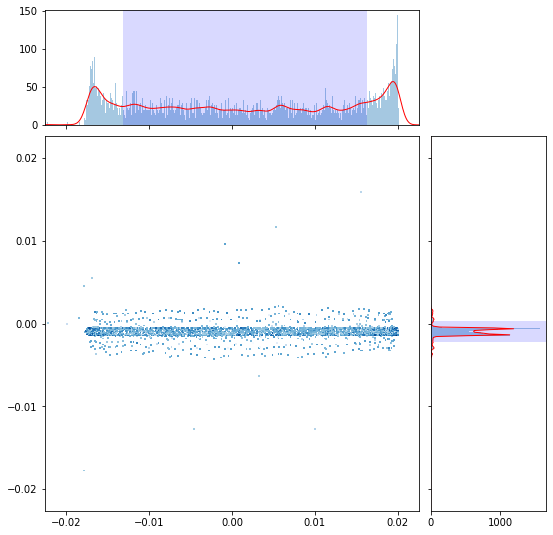

In [112]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the 2D histogram plot:
axScatter.hist2d(x_in,y_in,bins=[np.arange(x_min,x_max,dl),
                           np.arange(y_min,y_max,dl)],
                           weights=p_I,cmap='Blues',
                           norm=colors.LogNorm())

# now determine nice limits by hand:
binwidth = dl
xymax = np.max([np.max(np.fabs(x_in)), np.max(np.fabs(y_in))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)

(n,x,_) = axHistx.hist(x_in, bins=bins, density=True,alpha=0.4,weights=None)
for width_factor in [bandwidth(x_in)]:
    kde = stats.gaussian_kde(x_in)
    f = kde.covariance_factor()
    bw = f * x_in.std() * width_factor
    
    x_curve = axHistx.plot(bins, kde_sklearn(x_in, bins, bw), ('red'), linewidth=1, alpha=1)
    xx_out = x_curve[0].get_xdata()
    xy_out = x_curve[0].get_ydata()
    
    weighted_x_stats = DescrStatsW(xx_out,weights=xy_out)
    std = weighted_x_stats.std
    fit_mu = weighted_x_stats.mean
    FWHM = 2*np.sqrt(2*np.log(2))*std
    print ("FWHM_x:", FWHM)
    
    axHistx.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.15)

    
    
(n,y,_) = axHisty.hist(y_in, bins=bins, orientation='horizontal', density=True,alpha=0.4,weights=None)
for width_factor in [bandwidth(x_in)]:
    kde = stats.gaussian_kde(y_in)
    f = kde.covariance_factor()
    bw = f * y_in.std() * width_factor
    
    y_curve = axHisty.plot(kde_sklearn(y_in, bins, bw), bins, ('red'), linewidth=1, alpha=1)
    yx_out = y_curve[0].get_xdata()
    yy_out = y_curve[0].get_ydata()

    weighted_y_stats = DescrStatsW(yy_out,weights=yx_out)
    std = weighted_y_stats.std
    fit_mu = weighted_y_stats.mean
    FWHM = 2*np.sqrt(2*np.log(2))*std
    print ("FWHM_y:", FWHM)
    
    axHisty.axhspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.15)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
plt.show()




In [22]:
# # Error calculation. FFT.
# from scipy import fftpack

# sig = x_in
# time_step = 10

# sig_fft = fftpack.fft(sig)
# freqs = fftpack.fftfreq(sig.size,d=time_step)

# plt.hist(x_in,bins)
# plt.show()

# plt.hist(sig_fft, bins*50)
# plt.show()

# plt.plot(freqs,sig_fft.real,freqs,sig_fft.imag)
# plt.show()